 <p style = "font-size: 35px;font-weight: ;text-align:center;color:#800000"> <b>Yelp Reviews: Modern Market Sentiment & Topic Analysis vs Compititors </b> </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 06/10/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used get sentiments of reviewers toward the Modern Market and Compare them with its compitiors like Panera, Noodles & Co, Which Wich, Protein Bar <br>
Also take reviews and classifies them into topics/categories to understand what are topics/categories about which chatter is going on <br>
For example - Cleanliness, Hygiene, Food Service, Delivery Service, Location & Parking, Infrastructure .. etc.

**Pre Covid Date Range - April 2005 till February 2020**  <br>
**Post Covid Date Range - March 2020 till May 2021**  <br>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import json
import pickle
import re
import string 
import pandas as pd
import numpy as np
import warnings
import itertools
import requests
import datetime
import matplotlib
import seaborn as sns
import pytz
import pyodbc

from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from itertools import product
from fuzzywuzzy import fuzz
from pandas.io.json import json_normalize
from scipy import stats

utc=pytz.UTC
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
########################################################## Reviews Data #################################################################
#########################################################################################################################################

# Reading reviews data for competitors brands
df_whichwich = pd.read_csv('/User/yelpapi/Sentiment/WhichWich.csv')
df_whichwich = df_whichwich.loc[:, ~df_whichwich.columns.str.contains('^Unnamed')]
df_whichwich['Brand'] = 'Which Wich'

df_proteinbar = pd.read_csv('/User/yelpapi/Sentiment/ProteinBar.csv')
df_proteinbar = df_proteinbar.loc[:, ~df_proteinbar.columns.str.contains('^Unnamed')]
df_proteinbar['Brand'] = 'Protein Bar'

df_panera  = pd.read_csv('/User/yelpapi/Sentiment/Panera.csv')
df_panera = df_panera.loc[:, ~df_panera.columns.str.contains('^Unnamed')]
df_panera['Brand'] = 'Panera'

df_noodles = pd.read_csv('/User/yelpapi/Sentiment/Noodles.csv')
df_noodles = df_noodles.loc[:, ~df_noodles.columns.str.contains('^Unnamed')]
df_noodles['Brand'] = 'Noodles & Co.'

# Reding reviews data for Modern Market
df_modmarket = pd.read_csv('/User/yelpapi/Sentiment/Modern_Market.csv')
df_modmarket = df_modmarket.loc[:, ~df_modmarket.columns.str.contains('^Unnamed')]
df_modmarket['Brand'] = 'Modern Market'


df_review = df_panera.append([df_whichwich, df_proteinbar, 
                              df_noodles, df_modmarket])

df_review = df_review[df_review['date'].notnull()]

# Getting Month-Year from date
df_review['date'] = pd.to_datetime(df_review['date'], errors='coerce')
df_review['Date'] = df_review['date'].dt.date
df_review['month_year'] = df_review['Date'].apply(lambda x: x.strftime('%B-%Y'))

# Flags to be used in aggregation
df_review['Negative_flag'] = np.where(df_review['Flair_Score'] < 0,1,0)
df_review['Positive_flag'] = np.where(df_review['Flair_Score'] > 0,1,0)

df_grouped_review = df_review.groupby(['month_year', 'Brand'], as_index=False).agg({'Flair_Score' : 'mean',
                                                                                    'Positive_flag' : 'sum',
                                                                                    'Negative_flag' : 'sum',
                                                                                    'rating' : 'mean',
                                                                                    'text' : 'count'})
df_grouped_review.rename({'text' : 'No_of_Reviews',
                          'rating' : 'Rating',
                          'Positive_flag': 'Positive_Reviews',
                          'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# Calculating KPIs
df_grouped_review['Positive_Review_Percent'] = (df_grouped_review['Positive_Reviews']/df_grouped_review['No_of_Reviews'])*100
df_grouped_review['Negative_Review_Percent'] = (df_grouped_review['Negative_Reviews']/df_grouped_review['No_of_Reviews'])*100

In [4]:
df_review.reset_index(drop=True, inplace=True)

In [5]:
print(list(df_review.columns))
print(df_review.Sentiment_Type.value_counts())

['date', 'rating', 'text', 'username', 'sourceURLs', 'Flair_Score', 'Sentiment_Type', 'Brand', 'Join_ID', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating_y', 'transactions', 'phone', 'display_phone', 'distance', 'coordinates.latitude', 'coordinates.longitude', 'location.address1', 'location.address2', 'location.address3', 'location.city', 'location.zip_code', 'location.country', 'location.state', 'location.display_address', 'attributes.ambience', 'attributes.restaurants_take_out', 'attributes.restaurants_delivery', 'price', 'attributes.ambience.touristy', 'attributes.ambience.hipster', 'attributes.ambience.romantic', 'attributes.ambience.divey', 'attributes.ambience.intimate', 'attributes.ambience.trendy', 'attributes.ambience.upscale', 'attributes.ambience.classy', 'attributes.ambience.casual', 'Date', 'month_year', 'Negative_flag', 'Positive_flag']
Negative    94367
Positive    63176
Neutral      2765
Name: Sentiment_Type, dtype: int64


In [6]:
from nltk.corpus import stopwords
from textblob import Word
stop = stopwords.words('english')

# All the words of the text is converted into lower case using for condition and lambda function. Lambda function is an anonymous function.
df_review['text_1'] = df_review['text'].apply(lambda x:' '.join(x.lower() for x in x.split()))

# All the rows of the text in the data frame is checked for string punctuations, and these are filtered.
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df_review["text_1"] = df_review['text_1'].apply(remove_punctuations)

# Characters such as numbers or dot are removed using a regular expression.                             
df_review['text_1']= df_review['text_1'].str.replace('[^\w\s]','')

# Digits are removed from the text                            
df_review['text_1']= df_review['text_1'].apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))

# Stop words are removed at this stage.                            
df_review['text_1'] = df_review['text_1'].apply(lambda x:' '.join(x for x in x.split() if not x in stop))

# Words are filtered now, and different form of the same word is removed using lemmatization. With these, we have finished the data preprocessing.                            
df_review['text_1'] = df_review['text_1'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [7]:
# define the new set of wrods discovered for each topic from word2vec
clean_fsr =  ['unbussed', 'uncleaned', 'residue', 'antiseptic', 'spotless', 'stainless', 'immaculate', 'stain',
              'soiled', 'bussed', 'clean', 'uncleared', 'stained', 'dirty', 'cleansed', 'cleaning', 'spotted',
              'sullied', 'scrubbed', 'cleaned', 'wiped', 'washed', 'splatter', 'pristine', 'polished', 'grubby', 'unclean']

clean_restrooms = ['bathroom', 'washroom', 'loos', 'restroom', 'wc', 'sanitary', 'sanitation', 'urine']

food_hygiene = ['mildew', 'dry', 'lukewarm', 'mask', 'hygiene', 'safe', 'unhealthy', 'sterile', 'inedible',
                'hair', 'glove', 'contaminated', 'freshness', 'stale', 'bacteria', 'messy', 'overdone', 'tidy', 'filthy',
                'fresh', 'pure', 'dirty', 'musty', 'ungloved', 'uncooked', 'overcooked', 'undercooked', 'hygienic',
                'unclean']

food_service = ['meal', 'overpriced', 'worker', 'expensive', 'tasty', 'responsive', 'yummy', 'portion', 'selection', 'impeccable',
                'excellent', 'superb', 'nutritious', 'mediocre', 'subpar', 'presentation', 'variety', 'inattentive', 'delicious',
                'unattentive', 'exceptional', 'phenomenal', 'taste', 'flavorful', 'pleasant', 'marginal', 'outstanding', 'employee', 'soggy']

operations = ['loud', 'professionalism', 'noisy', 'waitress', 'worker', 'checkin', 'ease', 'checkout', 'waiter', 'easy', 'server', 'refund',
              'reservation', 'employee']

delivery_service = ['predictability', 'doordash', 'ubereats', 'delivery', 'grubhub', 'pick', 'estimate', 'deliver', 'seamless', 'postmates', 'pickup']

packaging_service = ['leak', 'package', 'packaging', 'visual', 'spill', 'packing', 'presentation', 'container', 'pack', 'box', 'parcel']

location_and_parking = ['curbside', 'valet', 'driving', 'drive', 'traffic', 'drivetime', 'carside', 'park', 'vehicle', 'parking']

infrastructure = ['seating', 'indoor', 'environment', 'atmosphere', 'outdoor', 'vibe', 'ambiance', 'roomy', 'outdoors', 'distanced',
                  'patio', 'spacious', 'distancing', 'ambience', 'buffet']

In [8]:
# list of synonyms/words related to topic chosen
def search_keywords(list_of_words, text, sentiment_type):
    counter_pos, counter_neg = 0, 0
    for i in list_of_words:
        if(text.lower().find(i) != -1):
            if(sentiment_type=='Positive'):
                counter_pos = 1
            elif(sentiment_type=='Negative'):
                counter_neg = 1
    return counter_pos, counter_neg


def search_keywords_add(list_of_words, x):
    counter = []
    for i in list_of_words:
        if(x.lower().find(i) != -1):
            counter.append(i)
    return counter


words = ['unbussed', 'uncleaned', 'residue', 'antiseptic', 'spotless', 'stainless', 'immaculate', 'stain',
         'soiled', 'bussed', 'clean', 'uncleared', 'stained', 'dirty', 'cleansed', 'cleaning', 'spotted',
         'sullied', 'scrubbed', 'cleaned', 'wiped', 'washed', 'splatter', 'pristine', 'polished', 'grubby',
         'unclean', 'bathroom', 'washroom', 'loos', 'restroom', 'wc', 'sanitary', 'sanitation', 'mildew', 
         'dry', 'lukewarm', 'mask', 'hygiene', 'safe', 'unhealthy', 'sterile', 'inedible', 'hair',
         'glove', 'contaminated', 'freshness', 'stale', 'bacteria', 'messy', 'overdone', 'tidy', 'filthy', 
         'fresh', 'pure', 'dirty', 'musty', 'ungloved', 'uncooked', 'urine', 'overcooked', 'undercooked',
         'hygienic', 'unclean', 'meal', 'overpriced', 'worker', 'expensive', 'tasty', 'responsive', 'yummy',
         'portion', 'selection', 'impeccable', 'excellent', 'superb', 'nutritious', 'mediocre', 'subpar',
         'presentation', 'variety', 'inattentive', 'delicious', 'unattentive', 'exceptional', 'phenomenal',
         'taste', 'flavorful', 'pleasant', 'marginal', 'outstanding', 'employee', 'soggy', 'loud', 'professionalism',
         'noisy', 'waitress', 'worker', 'checkin', 'ease', 'checkout', 'waiter', 'easy', 'server', 'refund',
         'reservation', 'employee', 'predictability', 'doordash', 'ubereats', 'delivery', 'grubhub', 'pick',
         'estimate', 'deliver', 'seamless', 'postmates', 'pickup', 'leak', 'package', 'packaging', 'visual',
         'spill', 'packing', 'presentation', 'container', 'pack', 'box', 'parcel', 'curbside', 'valet',
         'driving', 'drive', 'traffic', 'drivetime', 'carside', 'park', 'vehicle', 'parking', 'seating',
         'indoor', 'environment', 'atmosphere', 'outdoor', 'vibe', 'ambiance', 'roomy', 'outdoors', 'distanced',
         'patio', 'spacious', 'distancing', 'ambience', 'buffet']

In [9]:
# UDF to create pre-covid & post-covid flags 

def create_covid_flag(date):
    flag = ''
    date_before = datetime.datetime(2020, 3, 1)
    if date < date_before :
        flag = 'Pre-covid'
    else:
        flag = 'Post-covid'
    return flag

df_review['Covid-Flag'] = df_review.apply(lambda x: create_covid_flag(x['date']), axis=1)

In [10]:
def split_pre_post_covid(df):
    df_pre = df[df['Covid-Flag']=='Pre-covid']
    df_pre.reset_index(drop=True, inplace=True)
    
    df_post = df[df['Covid-Flag']=='Post-covid']
    df_post.reset_index(drop=True, inplace=True)
    
    return df_pre, df_post


df_review_pre, df_review_post = split_pre_post_covid(df_review)

# create competitor dataframe
df_competitor = df_review.copy(deep=True)
df_competitor = df_competitor[df_competitor['Brand']!='Modern Market']
df_competitor.reset_index(drop=True, inplace=True)

df_competitor_pre, df_competitor_post = split_pre_post_covid(df_competitor)

In [11]:
def split_on_brand(df, brand):
    df = df[df['Brand'] == brand]
    df.reset_index(drop=True, inplace=True)
    return df

df_mm_pre = split_on_brand(df_review_pre, 'Modern Market')
df_mm_post = split_on_brand(df_review_post, 'Modern Market')

df_panera_pre = split_on_brand(df_review_pre, 'Panera')
df_panera_post = split_on_brand(df_review_post, 'Panera')

df_noodle_pre = split_on_brand(df_review_pre, 'Noodles & Co.')
df_noodle_post = split_on_brand(df_review_post, 'Noodles & Co.')

df_whichwich_pre = split_on_brand(df_review_pre, 'Which Wich')
df_whichwich_post = split_on_brand(df_review_post, 'Which Wich')

df_proteinbar_pre = split_on_brand(df_review_pre, 'Protein Bar')
df_proteinbar_post = split_on_brand(df_review_post, 'Protein Bar')

In [12]:
def pre_post_sentiment_analysis(df_pre, df_post):
    list_pre, list_post = [], []
    sentiment_type = ['Positive', 'Negative', 'Neutral']
    for i in sentiment_type:
        list_pre.append(round((len(df_pre[df_pre.Sentiment_Type == i])/len(df_pre))*100, 2))
        list_post.append(round((len(df_post[df_post.Sentiment_Type == i])/len(df_post))*100, 2))
    big_list = list_pre + list_post
    return big_list

big_list_mm = pre_post_sentiment_analysis(df_mm_pre, df_mm_post)
big_list_panera = pre_post_sentiment_analysis(df_panera_pre, df_panera_post)
big_list_noodle = pre_post_sentiment_analysis(df_noodle_pre, df_noodle_post)
big_list_whichwich = pre_post_sentiment_analysis(df_whichwich_pre, df_whichwich_post)
big_list_protienbar = pre_post_sentiment_analysis(df_proteinbar_pre, df_proteinbar_post)

big_list_competitor = pre_post_sentiment_analysis(df_competitor_pre, df_competitor_post)

## Yelp Reviews: Modern Market Sentiment Analysis Pre & Post Covid (Compared with Panera and Noodles & Co)

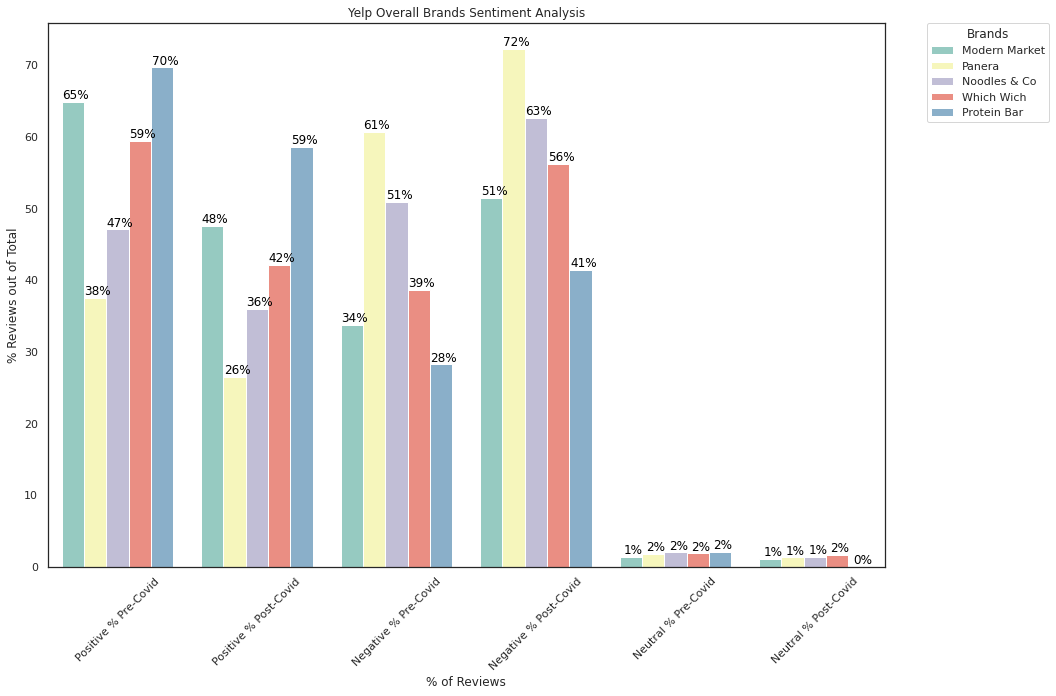

In [13]:
df_sentiment = pd.DataFrame({'Sentiment' : ['Positive % Pre-Covid', 'Negative % Pre-Covid', 'Neutral % Pre-Covid',
                                            'Positive % Post-Covid', 'Negative % Post-Covid', 'Neutral % Post-Covid'],
                             'Modern Market' : big_list_mm,
                             'Panera' : big_list_panera, 
                             'Noodles & Co' : big_list_noodle,
                             'Which Wich' : big_list_whichwich,
                             'Protein Bar' : big_list_protienbar})

new_order = ['Positive % Pre-Covid', 'Positive % Post-Covid', 'Negative % Pre-Covid', 
             'Negative % Post-Covid', 'Neutral % Pre-Covid', 'Neutral % Post-Covid']

sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(15,10)})
sns.set(style="white", color_codes=True)

ax = sns.barplot(x="Sentiment", y='value', hue='variable',
                 data=pd.melt(df_sentiment[['Sentiment', 'Modern Market', 'Panera', 'Noodles & Co', 'Which Wich', 'Protein Bar']], ['Sentiment']), order=new_order, palette = sns.color_palette("Set3"))
ax.set(xlabel='% of Reviews', ylabel='% Reviews out of Total', title='Yelp Overall Brands Sentiment Analysis')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.10, p.get_height()), ha='center', va='bottom', color= 'black')

plt.show()

Findings:

* <b>There was a descrease in positive sentiments for Modern Market post covid (from 65% to 48%, 17% decrease approximately)
* <b>A similar trend was also observed for the compititors brands Panera, Noodles & Co., Which Wich and Protein Bar which saw 12%, 11%, 17% and 11% descrease in positive sentiments post covid 19 pandemic
* <b>A jump in the negative sentiments was also observed across these brands, with Modern Market and Which Wich having the most 17% increase in negative sentiments

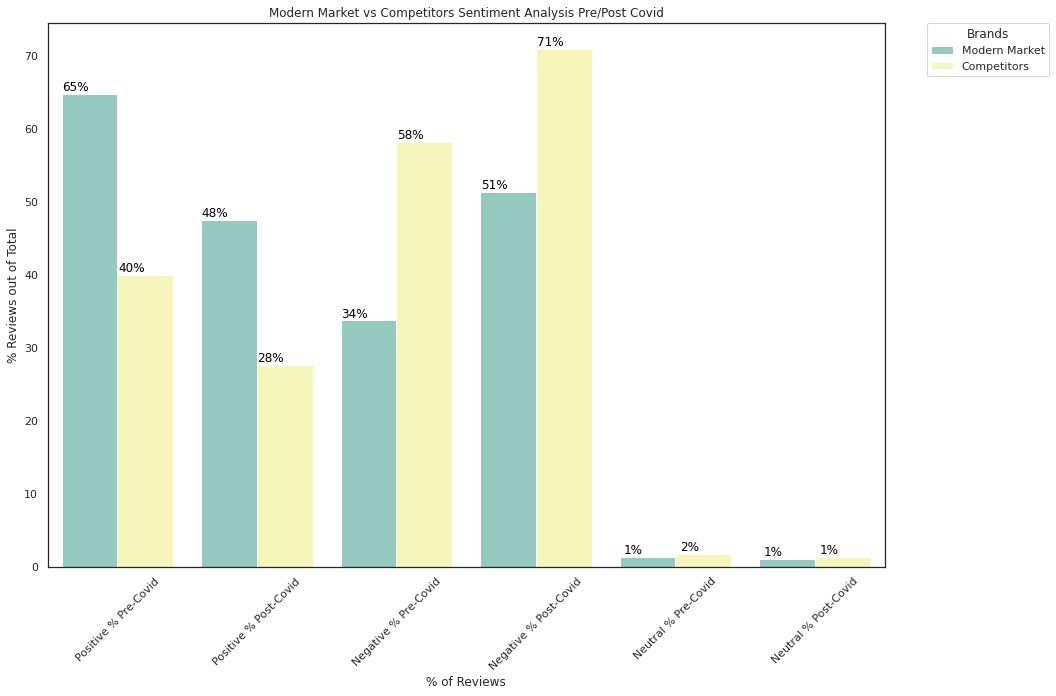

In [14]:
df_analysis_competitors = pd.DataFrame({'Sentiment' : ['Positive % Pre-Covid', 'Negative % Pre-Covid', 'Neutral % Pre-Covid',
                                            'Positive % Post-Covid', 'Negative % Post-Covid', 'Neutral % Post-Covid'],
                                        'Modern Market' : big_list_mm,
                                        'Competitors' : big_list_competitor
                                        })

new_order = ['Positive % Pre-Covid', 'Positive % Post-Covid', 'Negative % Pre-Covid', 
             'Negative % Post-Covid', 'Neutral % Pre-Covid', 'Neutral % Post-Covid']

sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(15,10)})
sns.set(style="white", color_codes=True)

ax = sns.barplot(x="Sentiment", y='value', hue='variable',
                 data=pd.melt(df_analysis_competitors[['Sentiment', 'Modern Market', 'Competitors']], ['Sentiment']), order=new_order, palette = sns.color_palette("Set3"))
ax.set(xlabel='% of Reviews', ylabel='% Reviews out of Total', title='Modern Market vs Competitors Sentiment Analysis Pre/Post Covid')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    ax.annotate('{:.0f}%'.format(p.get_height()), (p.get_x()+0.10, p.get_height()), ha='center', va='bottom', color= 'black')

plt.show()

Findings:
* <b>If we look at Modern Market vs Overall Sentiments of Competitors (Panera, Noodles & Co, Which Wich, Protein Bar), we observe that Competitors have a very low positive sentiment and very high negative sentiment which is good sign for Modern Market

In [15]:
print("Total No of review present for Modern Market : ", (df_mm_pre.shape[0]+df_mm_post.shape[0]))
print("Total No of review present for Panera : ", (df_panera_pre.shape[0]+df_panera_post.shape[0]))
print("Total No of review present for Noodles & co : ", (df_noodle_pre.shape[0]+df_noodle_post.shape[0]))
print("Total No of review present for Which Wich : ", (df_whichwich_pre.shape[0]+df_whichwich_post.shape[0]))
print("Total No of review present for Protein Bar : ", (df_proteinbar_pre.shape[0]+df_proteinbar_post.shape[0]))

Total No of review present for Modern Market :  4331
Total No of review present for Panera :  127290
Total No of review present for Noodles & co :  23293
Total No of review present for Which Wich :  3207
Total No of review present for Protein Bar :  2187


In [16]:
def topic_tagging_on_text(df):
    df['clean_fsr_mentions_positive'], df['clean_fsr_mentions_negative'] = zip(*df.apply(lambda x: search_keywords(clean_fsr, x['text_1'], x['Sentiment_Type']), axis=1))
    df['clean_restrooms_mentions_positive'], df['clean_restrooms_mentions_negative'] = zip(*df.apply(lambda x: search_keywords(clean_restrooms, x['text'], x['Sentiment_Type']), axis=1))
    df['food_hygiene_positive'], df['food_hygiene_negative'] = zip(*df.apply(lambda x: search_keywords(food_hygiene, x['text_1'], x['Sentiment_Type']), axis=1))
    df['food_service_positive'], df['food_service_negative'] = zip(*df.apply(lambda x: search_keywords(food_service, x['text_1'], x['Sentiment_Type']), axis=1))
    df['operations_positive'], df['operations_negative'] = zip(*df.apply(lambda x: search_keywords(operations, x['text_1'], x['Sentiment_Type']), axis=1))
    df['delivery_service_positive'], df['delivery_service_negative'] = zip(*df.apply(lambda x: search_keywords(delivery_service, x['text_1'], x['Sentiment_Type']), axis=1))
    df['packaging_service_positive'], df['packaging_service_negative'] = zip(*df.apply(lambda x: search_keywords(packaging_service, x['text_1'], x['Sentiment_Type']), axis=1))
    df['location_and_parking_positive'], df['location_and_parking_negative']  = zip(*df.apply(lambda x: search_keywords(location_and_parking, x['text_1'], x['Sentiment_Type']), axis=1))
    df['infrastructure_positive'], df['infrastructure_negative'] = zip(*df.apply(lambda x: search_keywords(infrastructure, x['text_1'], x['Sentiment_Type']), axis=1))
    
    df['Matching_Words'] = df.apply(lambda x: search_keywords_add(words, x['text_1']), axis=1)
    
    return df

In [17]:
df_mm_pre = topic_tagging_on_text(df_mm_pre)
df_mm_post = topic_tagging_on_text(df_mm_post)
df_competitor_pre = topic_tagging_on_text(df_competitor_pre)
df_competitor_post = topic_tagging_on_text(df_competitor_post)

## Yelp Positive Review Mentions for Modern Market & Compititors Pre-Post Covid

**To understand what kind of chatter that was going on the positive side of the reviews. We categorized the Reviews into 9 broad topics.<br>
And measured the % of mentions of these topics pre & post covid times.**



In [18]:
def positive_topic_category_percentage(df):
    percentage_list = []
    sentiment_type = ['clean_fsr_mentions_positive', 'clean_restrooms_mentions_positive', 'food_hygiene_positive',
                      'food_service_positive', 'operations_positive', 'delivery_service_positive', 
                      'packaging_service_positive', 'location_and_parking_positive', 'infrastructure_positive']
    for i in sentiment_type:
        percentage_list.append(round(((df[i].sum()/len(df))*100), 2))
        
    return percentage_list

In [19]:
# topics mentions percentage for modern market
mm_pre_ve = positive_topic_category_percentage(df_mm_pre)
mm_post_ve = positive_topic_category_percentage(df_mm_post)

# topics mentions percentage for all competitors combined
competitor_pre_posve = positive_topic_category_percentage(df_competitor_pre)
competitor_post_posve = positive_topic_category_percentage(df_competitor_post)

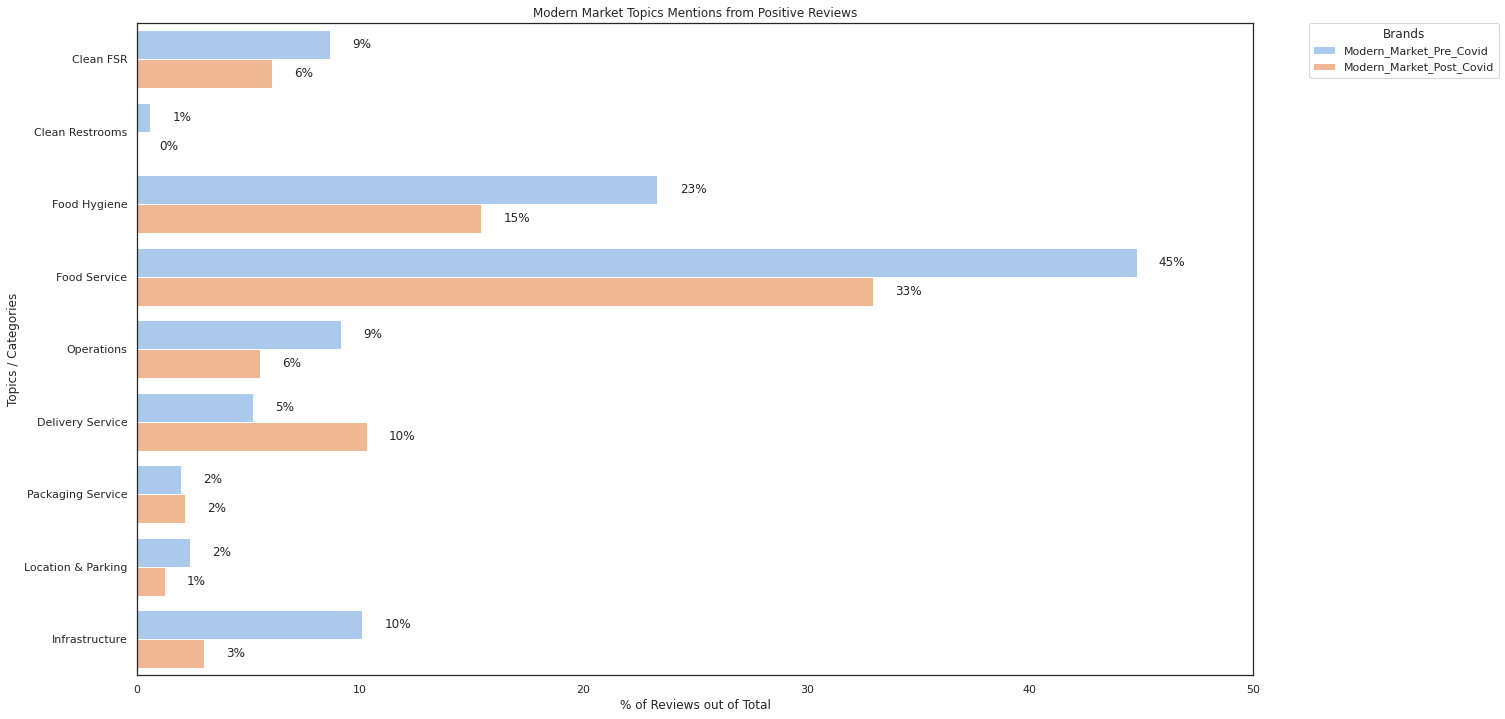

In [20]:
df_mm_positive = pd.DataFrame({'Topics' : ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 
                                         'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
                                         'Location & Parking', 'Infrastructure'],
                               'Modern_Market_Pre_Covid' : mm_pre_ve,
                               'Modern_Market_Post_Covid' : mm_post_ve})

new_order = ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
             'Location & Parking', 'Infrastructure']

sns.set_context("paper", rc={"font.size":20,"axes.titlesize":50,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(20,12)})
sns.set_style("white")

ax = sns.barplot(x="value", y="Topics", hue='variable',
                 data=pd.melt(df_mm_positive[['Topics', 'Modern_Market_Pre_Covid', 'Modern_Market_Post_Covid']], ['Topics']),
                 order=new_order,  palette = sns.color_palette("pastel"))

ax.set_xlim(0,50)
ax.set(xlabel='% of Reviews out of Total', ylabel='Topics / Categories', title='Modern Market Topics Mentions from Positive Reviews')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.show()

Findings:
* <b>Mentions about delivery service doubled Post Covid for positive reviews of Modern Market. <br>
* There was no significant increase in any other topic/category.

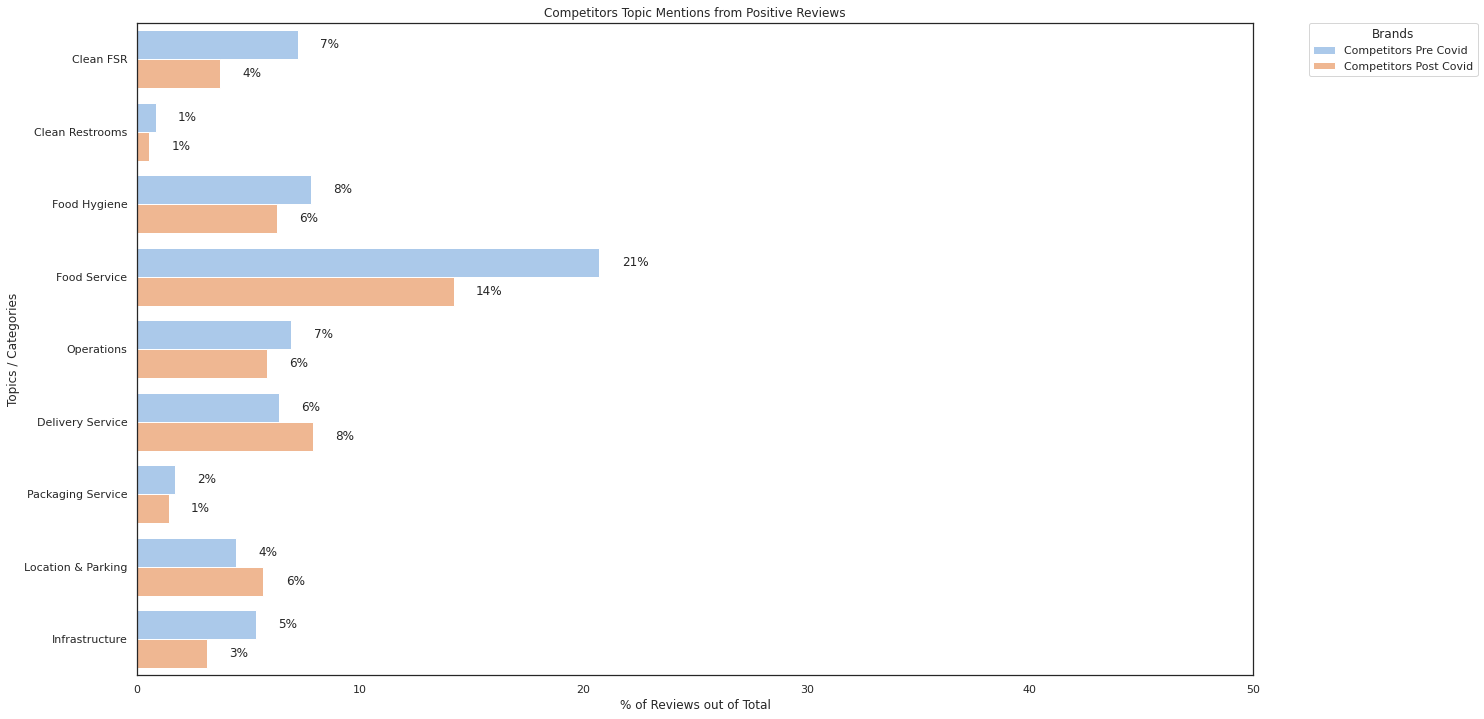

In [22]:
df_competitor_positive = pd.DataFrame({'Topics' : ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 
                                         'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
                                         'Location & Parking', 'Infrastructure'],
                                    'Competitors Pre Covid' : competitor_pre_posve,
                                    'Competitors Post Covid' : competitor_post_posve})

new_order = ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
             'Location & Parking', 'Infrastructure']

sns.set_context("paper", rc={"font.size":20,"axes.titlesize":50,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(20,12)})
sns.set_style("white")

ax = sns.barplot(x="value", y="Topics", hue='variable',
                 data=pd.melt(df_competitor_positive[['Topics', 'Competitors Pre Covid', 'Competitors Post Covid']], ['Topics']),
                 order=new_order,  palette = sns.color_palette("pastel"))

ax.set_xlim(0,50)
ax.set(xlabel='% of Reviews out of Total', ylabel='Topics / Categories', title='Competitors Topic Mentions from Positive Reviews')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.show()

Findings:
* <b>For the competitors (Panera, Noodles & Co, Which Wich and Protein Bar), chatter about Delivery Service and Location & Parking seemed to have increased a bit post covid. <br><b/>.

# Modern Market vs Compititors Positive Reviews Overall Analysis

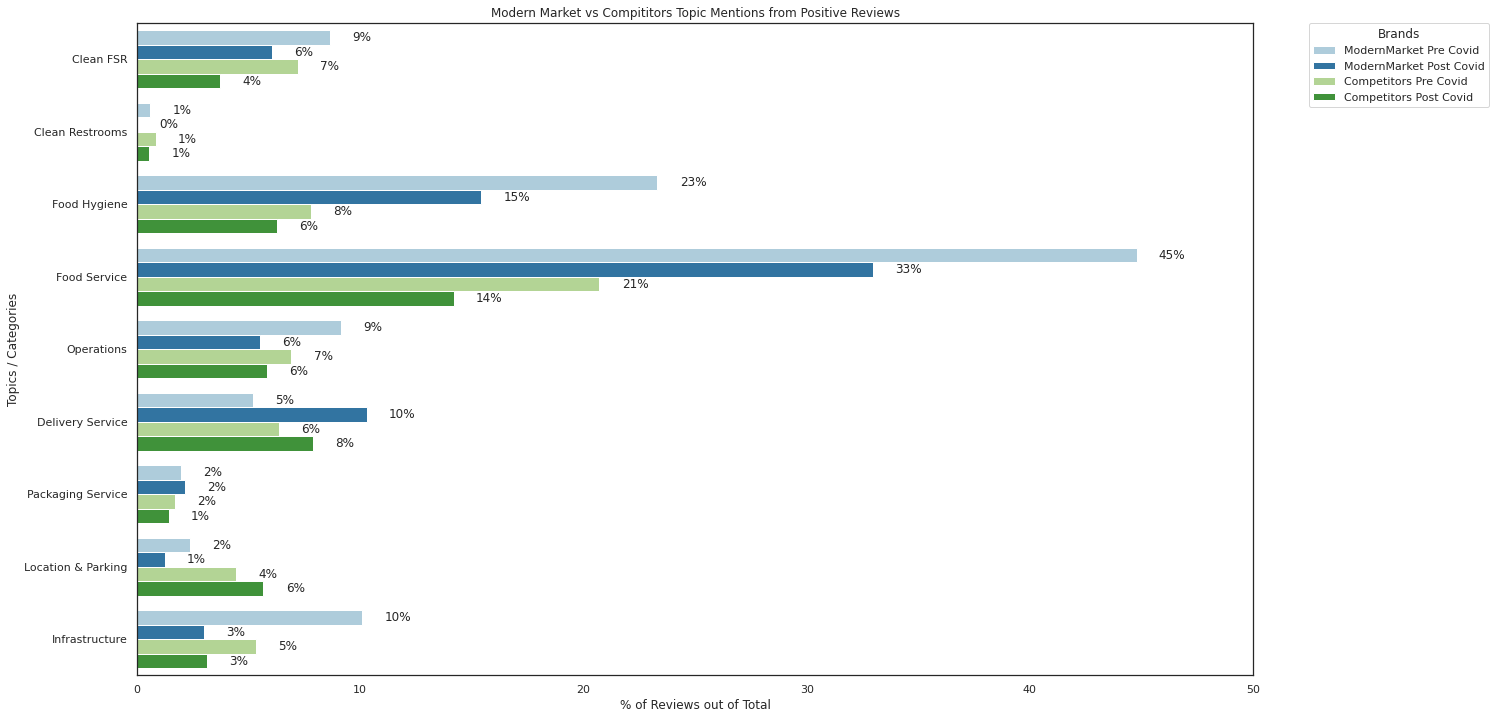

In [23]:
df_sentiment_positive = pd.DataFrame({'Topics' : ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 
                                         'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
                                         'Location & Parking', 'Infrastructure'],
                                    'ModernMarket Pre Covid' : mm_pre_ve,
                                    'ModernMarket Post Covid' : mm_post_ve,
                                    'Competitors Pre Covid' : competitor_pre_posve,
                                    'Competitors Post Covid' : competitor_post_posve})

new_order = ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
             'Location & Parking', 'Infrastructure']

sns.set_context("paper", rc={"font.size":20,"axes.titlesize":50,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(20,12)})
sns.set_style("white")

ax = sns.barplot(x="value", y="Topics", hue='variable',
                 data=pd.melt(df_sentiment_positive[['Topics', 'ModernMarket Pre Covid', 'ModernMarket Post Covid', 'Competitors Pre Covid',
                                                     'Competitors Post Covid']], ['Topics']),
                 order=new_order,  palette = sns.color_palette("Paired"))

ax.set_xlim(0,50)
ax.set(xlabel='% of Reviews out of Total', ylabel='Topics / Categories', title='Modern Market vs Compititors Topic Mentions from Positive Reviews')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.show()

Findings:
* <b>Delivery Service was the topics which saw significant increase in mentions post covid 19 pandemic <br>
* An increase in chatter about Location & Parking was also observed post covid across compititors

## Yelp Negative Review Mention for Modern Market & Compititors Pre-Post Covid for different Topics

In [24]:
def negative_topic_category_percentage(df):
    percentage_list = []
    sentiment_type = ['clean_fsr_mentions_negative', 'clean_restrooms_mentions_negative', 'food_hygiene_negative',
                      'food_service_negative', 'operations_negative', 'delivery_service_negative', 
                      'packaging_service_negative', 'location_and_parking_negative', 'infrastructure_negative']
    for i in sentiment_type:
        percentage_list.append(round(((df[i].sum()/len(df))*100), 2))
        
    return percentage_list

In [25]:
# topics mentions percentage for modern market
mm_pre_negve = negative_topic_category_percentage(df_mm_pre)
mm_post_negve = negative_topic_category_percentage(df_mm_post)

# topics mentions percentage for all competitors combined
competitor_pre_negve = negative_topic_category_percentage(df_competitor_pre)
competitor_post_negve = negative_topic_category_percentage(df_competitor_post)

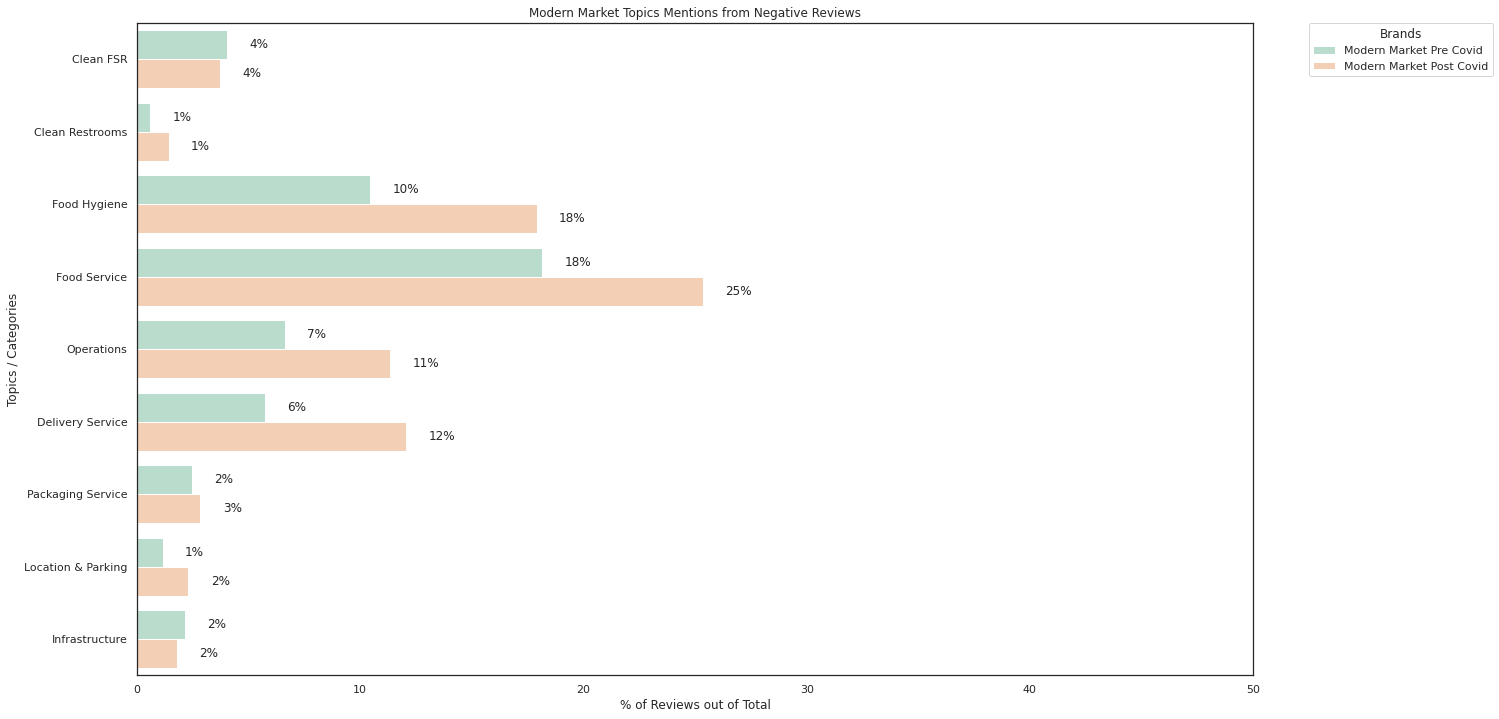

In [26]:
df_mm_negative = pd.DataFrame({'Topics' : ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 
                                         'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
                                         'Location & Parking', 'Infrastructure'],
                               'Modern Market Pre Covid' : mm_pre_negve,
                               'Modern Market Post Covid' : mm_post_negve})

new_order = ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
             'Location & Parking', 'Infrastructure']

sns.set_context("paper", rc={"font.size":20,"axes.titlesize":50,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(20,12)})
sns.set_style("white")

ax = sns.barplot(x="value", y="Topics", hue='variable',
                 data=pd.melt(df_mm_negative[['Topics', 'Modern Market Pre Covid', 'Modern Market Post Covid']], ['Topics']),
                 order=new_order,  palette = sns.color_palette("Pastel2"))

ax.set_xlim(0,50)
ax.set(xlabel='% of Reviews out of Total', ylabel='Topics / Categories', title='Modern Market Topics Mentions from Negative Reviews')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.show()

Findings:
* <b>Mentions about delivery service doubled Post Covid for negative reviews of Modern Market. <br>
* There was also significant increase in topics like <b>Food Hygiene, Food Service<b/>.

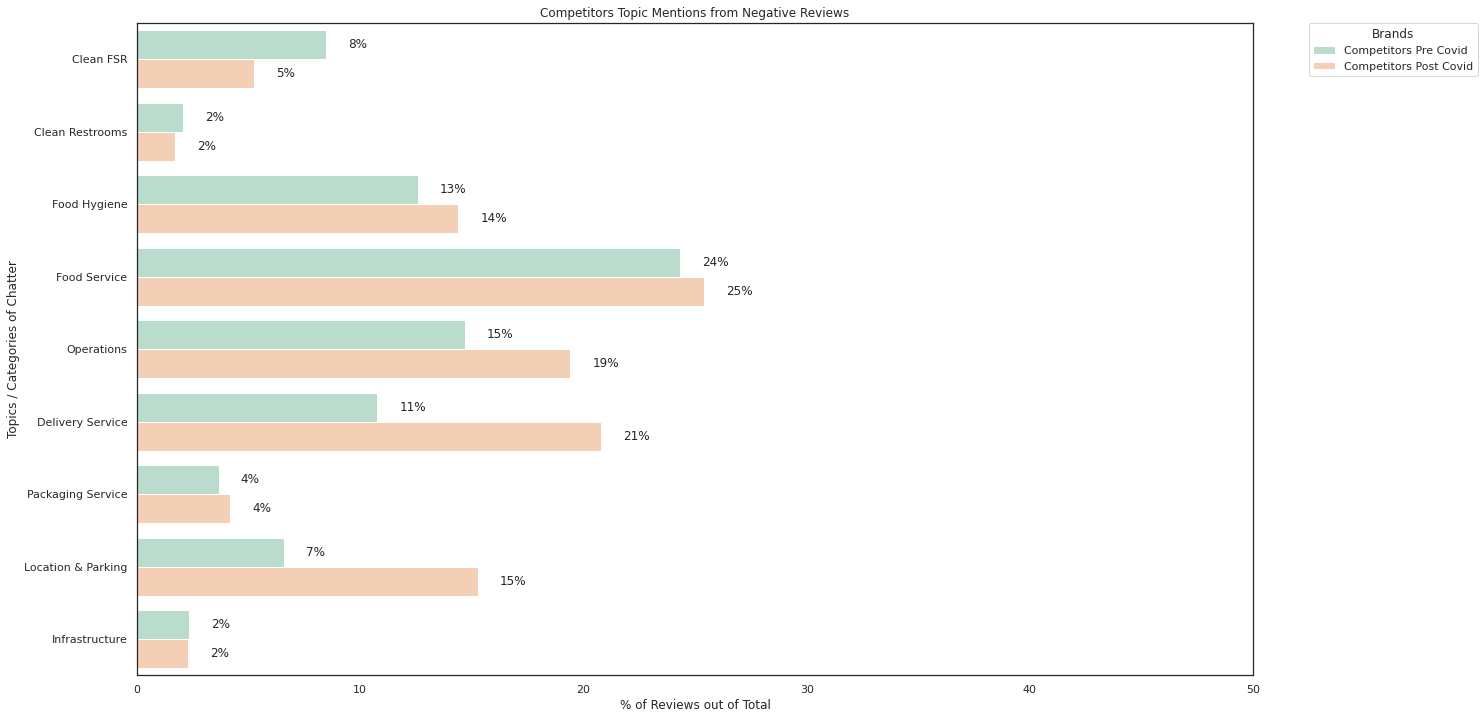

In [27]:
df_competitors_negative = pd.DataFrame({'Topics' : ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 
                                         'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
                                         'Location & Parking', 'Infrastructure'],
                                    'Competitors Pre Covid' : competitor_pre_negve,
                                    'Competitors Post Covid' : competitor_post_negve})

new_order = ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
             'Location & Parking', 'Infrastructure']

sns.set_context("paper", rc={"font.size":20,"axes.titlesize":50,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(20,12)})
sns.set_style("white")

ax = sns.barplot(x="value", y="Topics", hue='variable',
                 data=pd.melt(df_competitors_negative[['Topics', 'Competitors Pre Covid', 'Competitors Post Covid']], ['Topics']),
                 order=new_order,  palette = sns.color_palette("Pastel2"))

ax.set_xlim(0,50)
ax.set(xlabel='% of Reviews out of Total', ylabel='Topics / Categories of Chatter', title='Competitors Topic Mentions from Negative Reviews')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.show()

Findings:
* <b>Mentions about delivery service saw a significant increase Post Covid for negative reviews of Competitors <br>
* There was also significant increase in topics like <b>Operations and Location & Parking<b>

## Modern Market vs Compititors Negative Reviews Overall Analysis

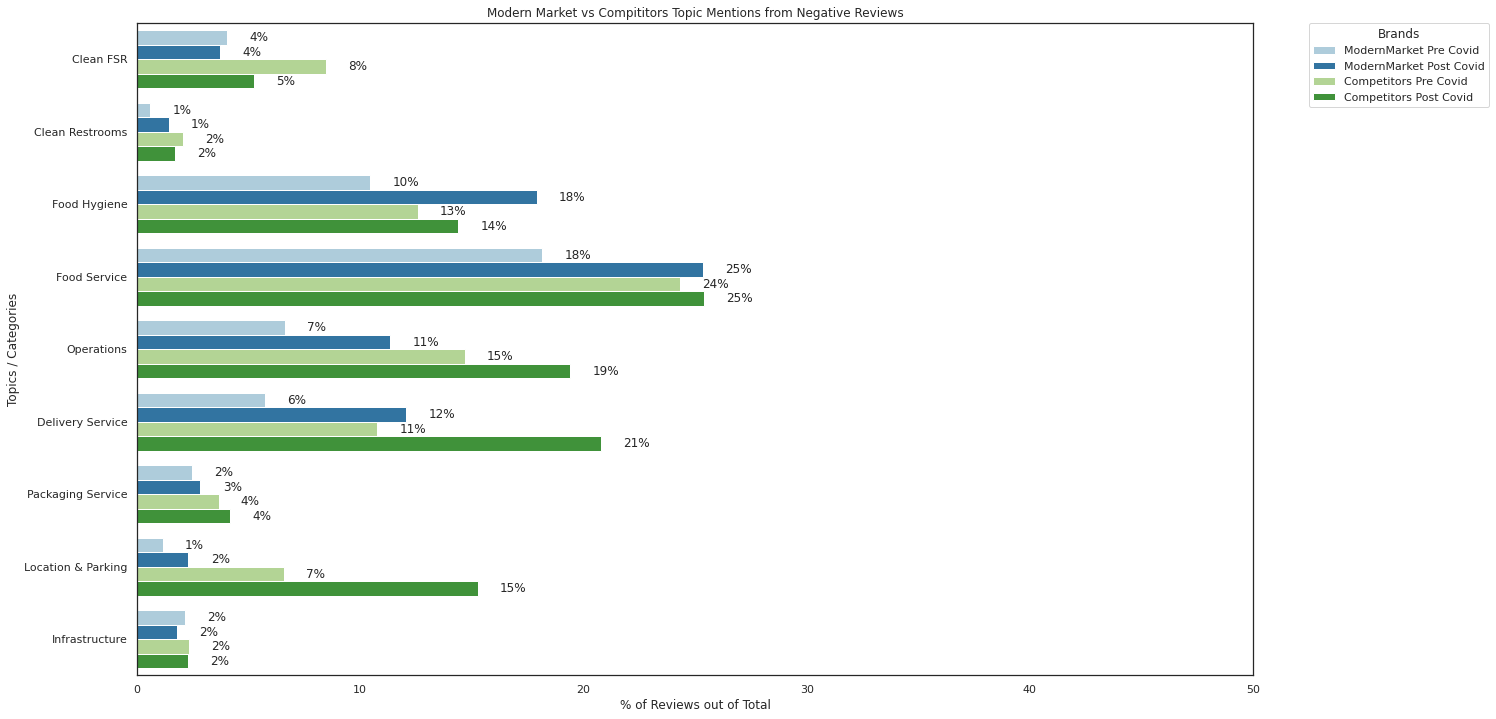

In [28]:
df_sentiment_negative = pd.DataFrame({'Topics' : ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 
                                         'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
                                         'Location & Parking', 'Infrastructure'],
                                    'ModernMarket Pre Covid' : mm_pre_negve,
                                    'ModernMarket Post Covid' : mm_post_negve,
                                    'Competitors Pre Covid' : competitor_pre_negve,
                                    'Competitors Post Covid' : competitor_post_negve})

new_order = ['Clean FSR', 'Clean Restrooms', 'Food Hygiene', 'Food Service', 'Operations', 'Delivery Service', 'Packaging Service',
             'Location & Parking', 'Infrastructure']

sns.set_context("paper", rc={"font.size":20,"axes.titlesize":50,"axes.labelsize":20})
sns.set(rc={'figure.figsize':(20,12)})
sns.set_style("white")

ax = sns.barplot(x="value", y="Topics", hue='variable',
                 data=pd.melt(df_sentiment_negative[['Topics', 'ModernMarket Pre Covid', 'ModernMarket Post Covid', 'Competitors Pre Covid',
                                                     'Competitors Post Covid']], ['Topics']),
                 order=new_order,  palette = sns.color_palette("Paired"))

ax.set_xlim(0,50)
ax.set(xlabel='% of Reviews out of Total', ylabel='Topics / Categories', title='Modern Market vs Compititors Topic Mentions from Negative Reviews')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Brands')

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}%'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.show()

Findings:
* <b>Food Hygiene, Operations & Delivery Service were the topics which were talked about the most from the Negative Reviews <br>
* Also an increase in mentions of <b>Food Serivce, Packaging Service and Location & Parking</b> was observed post covid times